In [ ]:
import pandas as pd
import math
import numpy as np
from collections import defaultdict
import requests
from io import StringIO
!pip install nltk
import string
import re
import nltk
from nltk.util import ngrams
from nltk.lm.preprocessing import pad_both_ends, padded_everygram_pipeline as pad_pipe
from nltk.lm import MLE, Lidstone
import csv
import scipy.stats as stats
import matplotlib.pyplot as plt
import codecs
from itertools import combinations
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from sklearn.linear_model import LinearRegression

In [ ]:
training_file_urls = {
    "German": "https://media.githubusercontent.com/media/DanielEylonTechnion/lang-computation-cognition-project/main/deu_news_2022_100K-sentences.txt",
    "English": "https://raw.githubusercontent.com/DanielEylonTechnion/lang-computation-cognition-project/main/eng_news_2020_100K-sentences.txt",
    "Dutch": "https://media.githubusercontent.com/media/DanielEylonTechnion/lang-computation-cognition-project/main/nld_news_2022_100K-sentences.txt",
}

validation_file_urls = {
    "German": "https://media.githubusercontent.com/media/DanielEylonTechnion/lang-computation-cognition-project/main/german_text.txt",
    "English": "https://media.githubusercontent.com/media/DanielEylonTechnion/lang-computation-cognition-project/main/english_text.txt",
    "Dutch": "https://media.githubusercontent.com/media/DanielEylonTechnion/lang-computation-cognition-project/main/dutch_text.txt",
}

readtime_file_urls = {
    "German": "https://raw.githubusercontent.com/DanielEylonTechnion/lang-computation-cognition-project/main/german_RTs.csv",
    "English": "https://raw.githubusercontent.com/DanielEylonTechnion/lang-computation-cognition-project/main/english_RTs.csv",
    "Dutch": "https://raw.githubusercontent.com/DanielEylonTechnion/lang-computation-cognition-project/main/dutch_RTs.csv",
}

validation_short_urls = {
    "German": validation_file_urls["German"],
    "English": "https://raw.githubusercontent.com/DanielEylonTechnion/lang-computation-cognition-project/main/english_text_short.txt",
    "Dutch": "https://raw.githubusercontent.com/DanielEylonTechnion/lang-computation-cognition-project/main/dutch_text_short.txt"
}

readtime_short_urls = {
    "German": readtime_file_urls["German"],
    "English": "https://raw.githubusercontent.com/DanielEylonTechnion/lang-computation-cognition-project/main/english_RTs_short.csv",
    "Dutch": "https://raw.githubusercontent.com/DanielEylonTechnion/lang-computation-cognition-project/main/dutch_RTs_short.csv"
}

In [ ]:
def load(training_file_url, readtime_file_url, validation_file_url):
    # Load the readtime data from the URL
    readtime_content = requests.get(readtime_file_url).text
    readtime_file = lang+"_RTs.csv"
    with open(readtime_file, 'w') as f:
      f.write(readtime_content)
    with open(readtime_file, 'r') as f:
      csvreader = csv.reader(f)
      readtime_data = list(csvreader)
    print(f"Training {lang} language model.")

    # Load the training text file from the URL and use it to train a bigram model
    training_content = requests.get(training_file_url).text
    train_sents = [s.strip().lower() for s in training_content.split("\n") if s.strip()]
    train_sents = [s.split(' ', 1)[1] for s in train_sents]
    train_sents = [re.sub(r'[^\w\s]','',s).split() for s in train_sents]
    train_data, padded_sents_train = pad_pipe(5, train_sents)

    # Load the validation text file
    val_content = requests.get(validation_file_url).text
    val_file = lang+"_val.csv"
    with open(val_file, 'w') as f:
      f.write(val_content)
    with open(val_file, 'r') as f:
      val_sents = [sent.strip().lower() for sent in f.readlines() if sent.strip()]
      val_sents = [re.sub(r'[^\w\s]','',s).split() for s in val_sents]
    val_data, padded_sents_val = pad_pipe(5, val_sents)
    padded_val_list = list(padded_sents_val)

    # return train_data, padded_sents_train, padded_val_list, readtime_data
    return train_sents, val_sents, readtime_data

In [ ]:
class bigram_model:
    def __init__(self, alpha):
        self.alpha = alpha
        self.bigram_counts = defaultdict(lambda: defaultdict(int))
        self.unigram_counts = defaultdict(int)
        self.vocab = set()

    def train(self, training_set):
        for sentence in training_set:
            if type(sentence) != list:
                sentence.strip()
                sentence = sentence.split()
            for i in range(len(sentence)):
                word = sentence[i]
                self.vocab.add(word)
                self.unigram_counts[word] += 1
                if i > 0:
                    prev_word = sentence[i-1]
                else:
                    prev_word = "<s>"
                self.bigram_counts[prev_word][word] += 1


    def prob(self, previous_word, next_word):
        numerator = self.bigram_counts[previous_word][next_word] + self.alpha
        denominator = self.unigram_counts[previous_word] + self.alpha * len(self.vocab)
        return numerator / denominator

    def perplexity(self, heldout_set):
        log_prob_sum = 0
        word_count = 0
        for sentence in heldout_set:
            if type(sentence) != list:
                sentence.strip()
                sentence = sentence.split()
            for i in range(len(sentence)):
                word = sentence[i]
                if i > 0:
                    prev_word = sentence[i-1]
                else:
                    prev_word = "<s>"
                log_prob_sum += math.log(self.prob(prev_word, word))
                word_count += 1
        perplexity = math.exp(-log_prob_sum / word_count)
        return perplexity

    def sentence_perplexity_surprisal(self, heldout_set):
        sen_perplexities = []
        sen_suprisals = []
        word_suprisals = []
        for sentence in heldout_set:
            if type(sentence) != list:
                sentence.strip()
                sentence = sentence.split()
            log_prob_sum = 0
            word_count = 0
            for i in range(len(sentence)):
                word = sentence[i]
                if i > 0:
                    prev_word = sentence[i-1]
                else:
                    prev_word = "<s>"
                probability = self.prob(prev_word, word)
                surprisal = -math.log(probability)
                log_prob_sum += surprisal
                word_count += 1
                sent_id = sentence.index(word)
                sent_pos = i
                word_length = len(word)
                entropy = self.compute_entropy(sentence)
                entry = self.compute_entry(prev_word)
                word_suprisals.append((word, sent_id, sent_pos, word_length, surprisal, entropy, entry, probability))
            sen_suprisals.append(log_prob_sum)
            perplexity = math.exp(log_prob_sum / word_count)
            sen_perplexities.append(perplexity)
        return sen_perplexities, sen_suprisals, word_suprisals

    def compute_entropy(self, sentence):
        entropy = 0
        for i in range(len(sentence)):
            word = sentence[i]
            if i > 0:
                prev_word = sentence[i-1]
            else:
                prev_word = "<s>"
            prob = self.prob(prev_word, word)
            entropy += prob * math.log(prob)
        return -entropy

    def compute_entry(self, previous_word):
        entry = 0
        for word in self.vocab:
            prob = self.prob(previous_word, word)
            if prob > 0:
                entry += prob * math.log(prob)
        return -entry

In [ ]:
# def calculate_suprisals(train_data, padded_sents_train, padded_val_list, readtime_data):
def calculate_suprisals(train_sents, val_sents, readtime_data):
  # training_words = [line.split() for line in train_sents]
  # val_words =  [line.split() for line in val_sents]

  best_alpha = 0.0028
  model = bigram_model(best_alpha)
  model.train(train_sents)
  val_perplexities, val_surprisals, word_surprisals = model.sentence_perplexity_surprisal(val_sents)
  word_surprisals.insert(0, ['word', 'sent_id', 'sent_pos', 'word_length', 'surprisal', 'entropy', 'entry', 'probability'])

  for rd, ws in zip(readtime_data, word_surprisals):
    rd.extend(ws)

    # Return the merged dataframe
  return readtime_data

In [ ]:
dfs = {}
for lang in training_file_urls:
    training_file_url = training_file_urls[lang]
    readtime_file_url = readtime_short_urls[lang]
    validation_file_url = validation_short_urls[lang]

    # Load and predict using the data from the URLs       validation_file_url)
    train_sents, val_sents, readtime_data = load(training_file_url,
                                                 readtime_file_url,
                                                 validation_file_url)
    data = calculate_suprisals(train_sents, val_sents, readtime_data)

    # Save the DataFrame to a CSV file
    output_file = f"{lang}_surprisals.csv"
    with open(output_file, 'w') as f:
      csvwriter = csv.writer(f)
      csvwriter.writerows(data)

    dfs[lang] = pd.read_csv(output_file)
print("Done.")

Training German language model.
Training English language model.
Training Dutch language model.
Done.


In [ ]:
dfs = {}
for lang in training_file_urls:
  output_file = f"{lang}_surprisals.csv"
  dfs[lang] = pd.read_csv(output_file)

combs = combinations(dfs.keys(), 2)

## Analysis

### Single-language Analysis

**************************************************
Language: German

First fixation time to suprisal correlation is 0.4062199211480508
Total read time to suprisal correlation is  0.4652435766577845

The variance of the first fixation time is 34747.99168012353
The variance of the total read time is 207798.40722008576
The variance of the surprisal is 20.52134974503523

The standard error of the first fixationt time is 4.282133938973102
The standard error of the total read time is 10.471683320618876
The standard error of the surprisal is 0.10406348210936302

First fixation time to suprisal regression coef is [[0.00987187]]
Total read time to suprisal regression coef is  [[0.00462341]]

The variance of the predictions based on first fixation time is 3.3845358413350906
The variance of the predictions based on total read time is 4.439534692093261

First fixation times unequal-variance t-test: [0.71524715], p-value: [0.47451471]
Total read times unequal-variance t-test: [0.24918915], p-value:

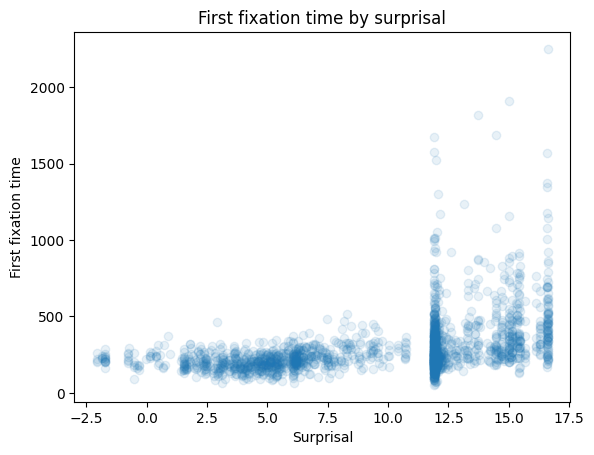

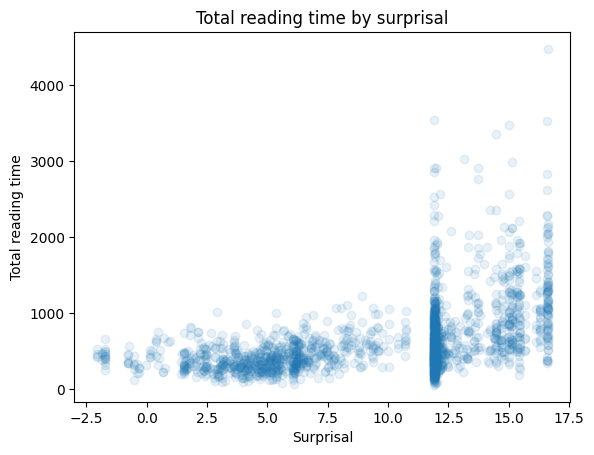

**************************************************
Language: English

First fixation time to suprisal correlation is 0.33036703531216255
Total read time to suprisal correlation is  0.39350731377958187

The variance of the first fixation time is 4315.141276276584
The variance of the total read time is 19144.057854337007
The variance of the surprisal is 18.138219773640905

The standard error of the first fixationt time is 0.7326499007940607
The standard error of the total read time is 1.5431778630303796
The standard error of the surprisal is 0.04750029595581641

First fixation time to suprisal regression coef is [[0.02141887]]
Total read time to suprisal regression coef is  [[0.01211248]]

The variance of the predictions based on first fixation time is 1.9794021836027007
The variance of the predictions based on total read time is 2.8083177841349714

First fixation times unequal-variance t-test: [3.75387779], p-value: [0.00017657]
Total read times unequal-variance t-test: [6.38830509], p-

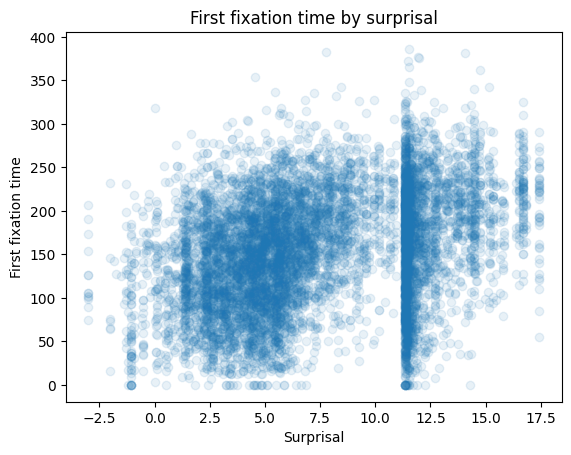

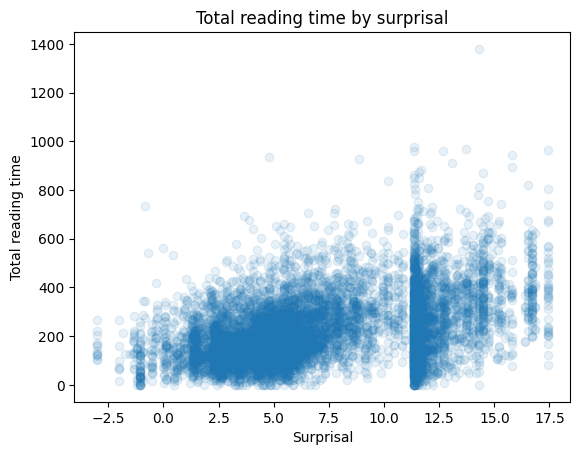

**************************************************
Language: Dutch

First fixation time to suprisal correlation is 0.3950214595338849
Total read time to suprisal correlation is  0.4097824282551288

The variance of the first fixation time is 3632.4975352229385
The variance of the total read time is 12037.764391105056
The variance of the surprisal is 19.177009481772526

The standard error of the first fixationt time is 0.610254918652431
The standard error of the total read time is 1.1109168237851936
The standard error of the surprisal is 0.044340344790151864

First fixation time to suprisal regression coef is [[0.02870176]]
Total read time to suprisal regression coef is  [[0.01635576]]

The variance of the predictions based on first fixation time is 2.9921112328689596
The variance of the predictions based on total read time is 3.2199047087834827

First fixation times unequal-variance t-test: [5.1596431], p-value: [2.65859996e-07]
Total read times unequal-variance t-test: [7.133546], p-va

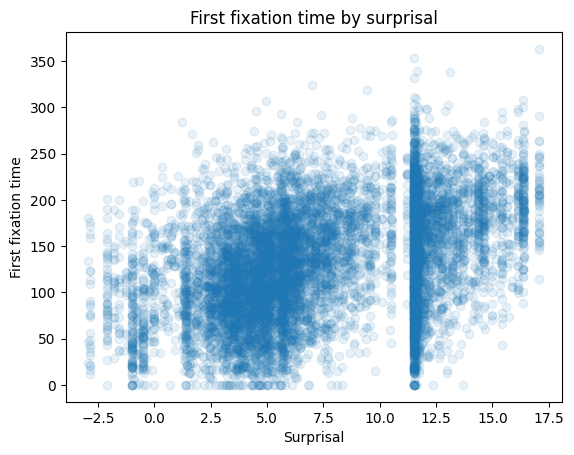

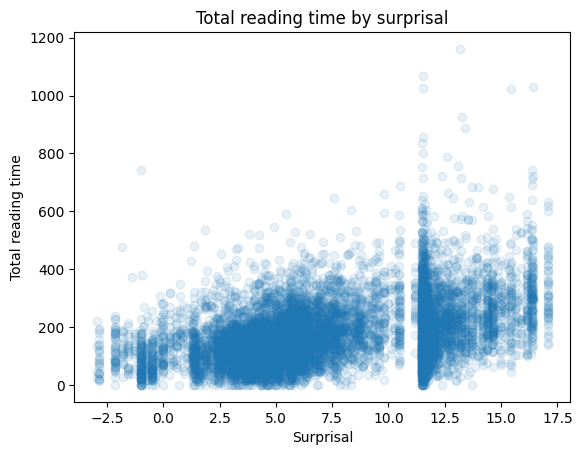

In [ ]:
for lang in dfs:
  print("*"*50 + f"\nLanguage: {lang}\n")
  first_corr = stats.pearsonr(dfs[lang]['surprisal'], dfs[lang]['firsttime'])[0]
  total_corr = stats.pearsonr(dfs[lang]['surprisal'], dfs[lang]['totaltime'])[0]

  first_var = dfs[lang]['firsttime'].var()
  total_var = dfs[lang]['totaltime'].var()
  surp_var = dfs[lang]['surprisal'].var()

  first_sem = dfs[lang]['firsttime'].sem()
  total_sem = dfs[lang]['totaltime'].sem()
  surp_sem = dfs[lang]['surprisal'].sem()

  first_arr = dfs[lang]['firsttime'].to_numpy().reshape(-1, 1)
  total_arr = dfs[lang]['totaltime'].to_numpy().reshape(-1, 1)
  surp_arr =  dfs[lang]['surprisal'].to_numpy().reshape(-1, 1)

  first_regressor = LinearRegression().fit(first_arr, surp_arr)
  first_preds = first_regressor.predict(first_arr)
  first_coef = first_regressor.coef_
  first_preds_var = np.var(first_preds)
  total_regressor = LinearRegression().fit(total_arr, surp_arr)
  total_preds = total_regressor.predict(total_arr)
  total_coef = total_regressor.coef_
  total_preds_var = np.var(total_preds)

  first_preds = first_preds[:1000,:]
  total_preds = total_preds[:1000,:]

  #FIXME! t-tests don't work
  first_ttest, first_pvalue = stats.ttest_ind(first_preds, surp_arr, equal_var=False)
  total_ttest, total_pvalue = stats.ttest_ind(total_preds, surp_arr, equal_var=False)

  print(f"First fixation time to suprisal correlation is {first_corr}")
  print(f"Total read time to suprisal correlation is  {total_corr}\n")

  print(f"The variance of the first fixation time is {first_var}")
  print(f"The variance of the total read time is {total_var}")
  print(f"The variance of the surprisal is {surp_var}\n")

  print(f"The standard error of the first fixationt time is {first_sem}")
  print(f"The standard error of the total read time is {total_sem}")
  print(f"The standard error of the surprisal is {surp_sem}\n")

  print(f"First fixation time to suprisal regression coef is {first_coef}")
  print(f"Total read time to suprisal regression coef is  {total_coef}\n")

  print(f"The variance of the predictions based on first fixation time is {first_preds_var}")
  print(f"The variance of the predictions based on total read time is {total_preds_var}\n")

  print(f'First fixation times unequal-variance t-test: {first_ttest}, p-value: {first_pvalue}')
  print(f'Total read times unequal-variance t-test: {total_ttest}, p-value: {total_pvalue}\n')

  plt.scatter(dfs[lang]['surprisal'], dfs[lang]['firsttime'],alpha=0.1)
  plt.xlabel('Surprisal')
  plt.ylabel('First fixation time')
  plt.title('First fixation time by surprisal')
  plt.show()

  plt.scatter(dfs[lang]['surprisal'], dfs[lang]['totaltime'],alpha=0.1)
  plt.xlabel('Surprisal')
  plt.ylabel('Total reading time')
  plt.title('Total reading time by surprisal')
  plt.show()

### Relations between languages

**************************************************
Languages: English and German

First fixation times 2-sample t-test: -53.67435224615986, p-value: 0.0
Total read times 2-sample t-test: -67.18386182217894, p-value: 0.0
Surprisals 2-sample t-test: -67.18386182217894, p-value: 0.0


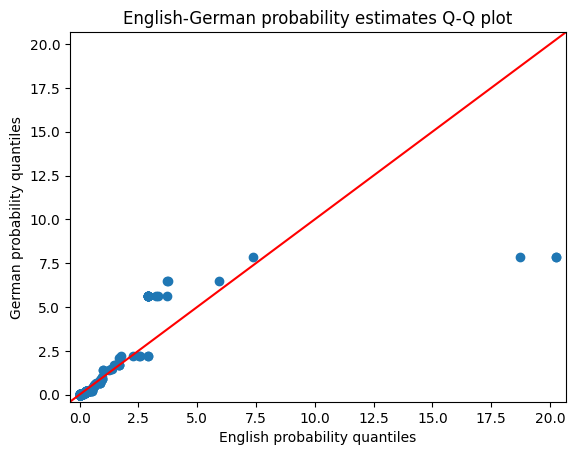

**************************************************
Languages: Dutch and German

First fixation times 2-sample t-test: -68.2844957482648, p-value: 0.0
Total read times 2-sample t-test: -86.68321377988474, p-value: 0.0
Surprisals 2-sample t-test: -86.68321377988474, p-value: 0.0


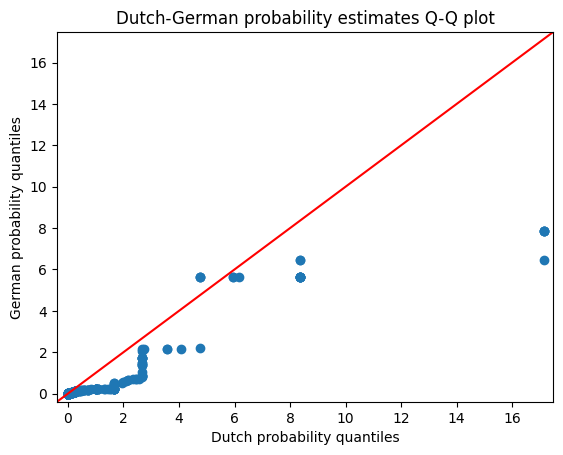

**************************************************
Languages: Dutch and English

First fixation times 2-sample t-test: -23.210641564520785, p-value: 1.9660873758207744e-117
Total read times 2-sample t-test: -28.500507688811396, p-value: 9.553521434308216e-175
Surprisals 2-sample t-test: -28.500507688811396, p-value: 9.553521434308216e-175


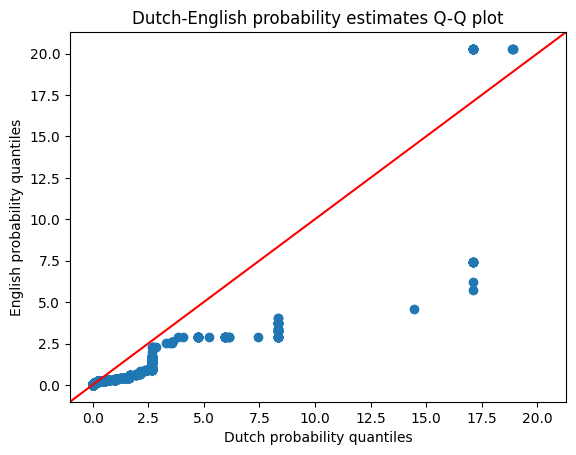

In [ ]:
for comb in combs:
  lang1 = comb[0]
  lang2 = comb[1]

  if len(dfs[lang1]) < len(dfs[lang2]):
    lang1, lang2 = lang2, lang1

  print("*"*50 + f"\nLanguages: {lang1} and {lang2}\n")

  surp_2ttest, surp_2pvalue = stats.ttest_ind(dfs[lang1]['surprisal'], dfs[lang2]['surprisal'])
  first_2ttest, first_2pvalue = stats.ttest_ind(dfs[lang1]['firsttime'], dfs[lang2]['firsttime'])
  total_2ttest, total_2pvalue = stats.ttest_ind(dfs[lang1]['totaltime'], dfs[lang2]['totaltime'])

  print(f'First fixation times 2-sample t-test: {first_2ttest}, p-value: {first_2pvalue}')
  print(f'Total read times 2-sample t-test: {total_2ttest}, p-value: {total_2pvalue}')
  print(f'Surprisals 2-sample t-test: {total_2ttest}, p-value: {total_2pvalue}')

  qqplot_2samples(dfs[lang1]['probability'],
                  dfs[lang2]['probability'],
                  line="45")
  plt.xlabel(f"{lang1} probability quantiles")
  plt.ylabel(f"{lang2} probability quantiles")
  plt.title(f"{lang1}-{lang2} probability estimates Q-Q plot")
  plt.show()